# Análisis exploratorio (EDA) de la base de datos EE1

## Importacion de librerias y archivos CSV

In [1]:
!pip install pymysql


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.7 MB/s eta 0:00:00


Importamos las librerias que vamos a utilizar.

In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
from sqlalchemy import create_engine, Column, String, Integer, Float, Date, ForeignKey,text
from sqlalchemy.orm import sessionmaker, declarative_base
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Leer los CSVs en DataFrames
country_data =  pd.read_csv("ufc_country_data.csv")
events_stats = pd.read_csv("ufc_events_stats.csv")
fighters_stats = pd.read_csv("ufc_fighters_stats.csv")

## Limpieza, creacion de tablas e importacion de datos

###  Limpieza de los archivos csv

Ahora vemos cada csv y las columnas que tiene, posibles valores nulos etc...

#### 1) CSV country_data.csv

In [4]:
country_data.head()

,country,country_code,avg_temperature_celsius,avg_elevation_meters,gdp_2023_billion_usd,unemployment_rate_2023,total_population,female_pop_total_percent,male_pop_total_percent,population_growth_2023,working_age_pop_percent,percent_of_internet_users,percent_of_internet_users_2022,dependency_ratio_2023
0,Angola,AGO,21.77,1112.0,84.824654,NaN,36749906,50.525887,49.474113,3.080655,52.616286,NaN,39.2935,90.055225
1,Argentina,ARG,16.30,595.0,646.075278,6.139,45538401,50.378178,49.621822,0.286976,65.606321,89.2290,88.3754,52.424337
2,Australia,AUS,22.05,330.0,1728.057317,3.668,26658948,50.385263,49.614737,2.447466,64.585692,NaN,94.8762,54.833055
3,Austria,AUT,7.44,910.0,511.685204,5.264,9131761,50.779585,49.220415,0.989465,65.533345,95.3347,93.6141,52.594084
4,Brazil,BRA,25.44,320.0,2173.665656,7.947,211140729,50.784928,49.215072,0.395929,69.430416,84.1506,80.5278,44.029095


In [5]:
print(country_data.isnull().sum())

country                            0
country_code                       0
avg_temperature_celsius            1
avg_elevation_meters               1
gdp_2023_billion_usd               0
unemployment_rate_2023            12
total_population                   0
female_pop_total_percent           0
male_pop_total_percent             0
population_growth_2023             0
working_age_pop_percent            0
percent_of_internet_users         19
percent_of_internet_users_2022     2
dependency_ratio_2023              0
dtype: int64


Vemos que las en la columna avg_temperature_celsius y avg_elevation_meters hay una fila vacia, vamos a comprobar si es la misma 

In [6]:
print(country_data[country_data["avg_temperature_celsius"].isnull()]["country"])
print(country_data[country_data["avg_elevation_meters"].isnull()]["country"])



20    Kyrgyz Republic
Name: country, dtype: object
20    Kyrgyz Republic
Name: country, dtype: object


Vemos que es el mismo pais *"Kyrgyz Republic"*, para ver si se trata de un pais relevante,comprobamos si hay algun luchador o algun evento en este pais:

(También lo comprobamos con *"Kyrgyzstan"* por si acaso aparece distinto en el otro csv)

In [7]:
print(fighters_stats[(fighters_stats["country"] == 'Kyrgyz Republic') | (fighters_stats["country"] == 'Kyrgyzstan')].shape[0])


2


In [8]:
print(events_stats[(events_stats["country"]=='Kyrgyz Republic') | (events_stats["country"] == 'Kyrgyzstan')].shape[0])

0


Vemos que existe alguna relacion entre este pais y el resto de tablas, y por lo tanto decidimos quitar las columnas avg_temperature_celsius y avg_elevation_meters, junto con el resto de columnas con datos vacios , las columnas unemployment_rate_2023, percent_of_internet_users, percent_of_internet_users_2022. Dado que estos datos no son esenciales para nuestro análisis exploratorio, podemos prescindir de ellos y eliminar estas columnas. 

In [9]:
country_data_clean =country_data.drop(columns=["unemployment_rate_2023","percent_of_internet_users","percent_of_internet_users_2022","avg_temperature_celsius","avg_elevation_meters"])

In [10]:
print(country_data_clean.isnull().sum())

country                     0
country_code                0
gdp_2023_billion_usd        0
total_population            0
female_pop_total_percent    0
male_pop_total_percent      0
population_growth_2023      0
working_age_pop_percent     0
dependency_ratio_2023       0
dtype: int64


#### 2) CSV ufc_events_stats.csv

In [11]:
events_stats

,event_category,fighter_1,fighter_2,date,venue,city,state_province,country,attendance
0,UFC on ESPN,Covington,Buckley,"Dec 14, 2024",Amalie Arena,Tampa,Florida,United States,18625.0
1,UFC 310,Pantoja,Asakura,"Dec 7, 2024",T-Mobile Arena,Las Vegas,Nevada,United States,18648.0
2,UFC Fight Night,Yan,Figueiredo,"Nov 23, 2024",Galaxy Arena,Macau,SAR,China,12615.0
3,UFC 309,Jones,Miocic,"Nov 16, 2024",Madison Square Garden,New York City,New York,United States,20200.0
4,UFC Fight Night,Magny,Prates,"Nov 9, 2024",UFC Apex,Las Vegas,Nevada,United States,NaN
...,...,...,...,...,...,...,...,...,...
720,UFC 5,The Return of the Beast,NaN,"Apr 7, 1995",Independence Arena,Charlotte,North Carolina,United States,6000.0
721,UFC 4,Revenge of the Warriors,NaN,"Dec 16, 1994",Expo Square Pavilion,Tulsa,Oklahoma,United States,5857.0
722,UFC 3,The American Dream,NaN,"Sep 9, 1994",Grady Cole Center,Charlotte,North Carolina,United States,3000.0
723,UFC 2,No Way Out,NaN,"Mar 11, 1994",Mammoth Gardens,Denver,Colorado,United States,2000.0


In [12]:
print(events_stats.isnull().sum())

event_category      0
fighter_1           8
fighter_2         108
date                0
venue               0
city                0
state_province    143
country             0
attendance        104
dtype: int64


Vemos que hay algun nombre de luchador vacio, sobre todo en los eventos mas antiguos, esto es debido a que no se anunciaban con cabezas de cartelera, es decir, con los nombres de los luchadores, si no que se anunciaban con un determinado nombre de evento.

Por lo tanto entramos en el dilema de si prescindir, de los nombres de cartelera y por lo tanto solo tener el nombre de la categoría del evento o prescindir de los eventos que no tengan  nombres de cartelera.

Los eventos que se perderian si realizamos la segunda opcion seria de un 15% es una cantidad relativamente grande, ademas hay que tener en cuenta que fighter_1 y fighter_2 no es un dato que representaria todos los luchadores que hay en ese evento, por lo tanto, lo mejor seria prescindir de estas dos columnas para no complicar demasiado las relaciones.

In [13]:
events_stats = events_stats.drop(columns=["fighter_1","fighter_2"])

In [14]:
print(events_stats.isnull().sum())

event_category      0
date                0
venue               0
city                0
state_province    143
country             0
attendance        104
dtype: int64


Ahora tenemos como columnas con datos faltantes state_province (representa el estado de la ciudad donde se realiza el evento, es logico que para ciudades que no esten en EEUU y por lo tanto no pertenezcan a ningun estado, esten vacios) y la columna attendance que representa el aforo completado en cada evento, podriamos usar alguna tecnica como KNN imputer para rellenar estos valores. Como state province no es un dato imprescindible para el analisis exploratorio, nos deshacemos de esta columna.

In [15]:
# Eliminar la columna state_province
events_stats_clean = events_stats.drop(columns=["state_province"]).copy()

# Crear un KNN Imputer con un valor de 5 vecinos
imputer = KNNImputer(n_neighbors=5)

# Aplicar KNN Imputer solo a la columna attendance
events_stats_clean["attendance"] = imputer.fit_transform(events_stats_clean[["attendance"]])



In [16]:
print(events_stats_clean.isnull().sum())

event_category    0
date              0
venue             0
city              0
country           0
attendance        0
dtype: int64


#### 3) CSV ufc_fighters_stats.csv

In [17]:
fighters_stats

,first_name,last_name,nickname,city,country,age,wins,losses,draws,win_percent,lose_percent,num_of_fights,weight_division,height_ft,weight_lbs,arm_reach_inch,leg_reach_inch,fighting_style,debut
0,Islam,Makhachev,NaN,Dagestan Republic,Russia,33,26,1,0,96.296296,3.703704,27,Lightweight Division,5.833333,155.0,70.5,40.5,Sambo,2015-05-23
1,Jon,Jones,Bones,Rochester,United States,37,28,1,0,96.551724,3.448276,29,Heavyweight Division,6.333333,237.6,84.5,45.0,NaN,2008-08-09
2,Alex,Pereira,Poatan,São Bernardo do Campo,Brazil,37,12,2,0,85.714286,14.285714,14,Light Heavyweight Division,6.333333,205.0,79.0,44.0,Kickboxer,2021-11-06
3,Ilia,Topuria,El Matador,NaN,Germany,27,16,0,0,100.000000,0.000000,16,Featherweight Division,5.583333,145.0,69.0,37.0,Brazilian Jiu-Jitsu,2020-10-10
4,Belal,Muhammad,Remember The Name,Chicago,United States,36,24,3,0,88.888889,11.111111,27,Welterweight Division,5.916667,169.0,72.0,40.0,NaN,2016-07-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Yana,Santos,NaN,NaN,Russia,35,15,8,0,65.217391,34.782609,23,Women's Bantamweight Division,5.500000,135.5,68.5,40.0,MMA,2018-03-03
163,Julia,Avila,Raging Panda,Los Angeles,United States,36,9,3,0,75.000000,25.000000,12,Women's Bantamweight Division,5.583333,135.5,68.0,38.0,NaN,2019-07-06
164,Ailin,Perez,Fiona,CABA,Argentina,30,11,2,0,84.615385,15.384615,13,Women's Bantamweight Division,5.416667,136.5,66.0,36.0,Kung Fu,2022-09-03
165,Jacqueline,Cavalcanti,NaN,NaN,Brazil,27,8,1,0,88.888889,11.111111,9,Women's Bantamweight Division,5.666667,135.0,70.0,41.0,Striker,2023-09-02


In [18]:
print(fighters_stats.isnull().sum())

first_name          0
last_name           0
nickname           48
city               28
country             0
age                 0
wins                0
losses              0
draws               0
win_percent         0
lose_percent        0
num_of_fights       0
weight_division     0
height_ft           0
weight_lbs          0
arm_reach_inch      0
leg_reach_inch      0
fighting_style     16
debut               0
dtype: int64


Las columnas con valores nulos corresponden al apodo de los luchadores, la ciudad de origen y su estilo de lucha. Dado que estos datos no son esenciales para nuestro análisis exploratorio, podemos prescindir de ellos y eliminar estas columnas.

In [19]:
fighters_stats_clean =fighters_stats.drop(columns=['nickname','fighting_style','city'])

In [20]:
print(fighters_stats_clean.isnull().sum())

first_name         0
last_name          0
country            0
age                0
wins               0
losses             0
draws              0
win_percent        0
lose_percent       0
num_of_fights      0
weight_division    0
height_ft          0
weight_lbs         0
arm_reach_inch     0
leg_reach_inch     0
debut              0
dtype: int64


### Analisis de relaciones

Una vez ya no tenemos valores nulos, procedemos a la comprobación de datos relacionados en las distintas tablas:

Como relaciones tendriamos:
1) La columna country de ufc_country_data.csv con la columna country de ufc_fighter_stats.csv
2) La columna country de ufc_country_data.csv con la columna country de ufc_events_stats.csv

Comprobamos que no hayan inconsistencias o diferencias en los nombres de los paises:

In [21]:
# Verificar qué países en fighters_stats_clean no están en country_data_clean
missing_countries_fighters = fighters_stats_clean[~fighters_stats_clean["country"].isin(country_data_clean["country"])]
print("Países en fighters_stats_clean que no están en country_data_clean:")
print(missing_countries_fighters["country"].unique())

missing_countries_country1 = country_data_clean[~country_data_clean["country"].isin(fighters_stats_clean["country"])]
print("Países en country_data_clean que no están en fighters_stats_clean:")
print(missing_countries_country1["country"].unique())

# Verificar qué países en events_stats_clean no están en country_data_clean
missing_countries_events = events_stats_clean[~events_stats_clean["country"].isin(country_data_clean["country"])] 
print("Países en events_stats_clean que no están en country_data_clean:")
print(missing_countries_events["country"].unique())

missing_countries_country2 = country_data_clean[~country_data_clean["country"].isin(events_stats_clean["country"])]
print("Países en country_data_clean que no están en events_stats_clean:")
print(missing_countries_country2["country"].unique())


Países en fighters_stats_clean que no están en country_data_clean:
['Russia' 'Myanmar (Burma)' 'Iran' 'Kyrgyzstan']
Países en country_data_clean que no están en fighters_stats_clean:
['Iran, Islamic Rep.' 'Kyrgyz Republic' 'Myanmar' 'Russian Federation'
 'United Arab Emirates']
Países en events_stats_clean que no están en country_data_clean:
['Saudi Arabia' 'Singapore' 'South Korea' 'Russia' 'Denmark' 'Uruguay'
 'Czech Republic' 'Chile' 'Netherlands' 'Philippines' 'Croatia'
 'Puerto Rico']
Países en country_data_clean que no están en events_stats_clean:
['Angola' 'Austria' 'Czechia' 'Dominican Republic' 'Ecuador' 'Georgia'
 'Iran, Islamic Rep.' 'Iraq' 'Italy' 'Jamaica' 'Kazakhstan'
 'Kyrgyz Republic' 'Moldova' 'Myanmar' 'Nigeria' 'Russian Federation'
 'South Africa' 'Spain' 'Suriname' 'Switzerland' 'Ukraine' 'Uzbekistan']


Observamos, que hay varios paises que son los mismos pero estan expresados con un nombre distinto en cada dataframe, por lo tanto usamos diccionarios para corregir estos errores:

In [22]:
# Diccionario de corrección inicial de nombres de países
initial_country_corrections = {
    "Russia": "Russian Federation",
    "Myanmar (Burma)": "Myanmar",
    "Iran": "Iran, Islamic Rep.",
    "Kyrgyzstan": "Kyrgyz Republic",
    "Czech Republic": "Czechia",
    "South Korea": "Korea, Rep.",
    "United States": "United States of America",
    "UAE": "United Arab Emirates",
    "UK": "United Kingdom"
}

# Diccionario de corrección final de nombres de países
final_country_corrections = {
    "United States of America": "United States",
    "UAE": "United Arab Emirates"
}

# Aplicar correcciones iniciales
for df in [fighters_stats_clean, events_stats_clean]:
    df["country"] = df["country"].replace(initial_country_corrections)

# Aplicar correcciones finales
for df in [fighters_stats_clean, events_stats_clean, country_data_clean]:
    df["country"] = df["country"].replace(final_country_corrections)

# Verificación de coherencia en los datos
def check_missing_countries(source_df, reference_df, source_name, reference_name):
    missing_countries = source_df[~source_df["country"].isin(reference_df["country"])]["country"].unique()
    print(f"\nPaíses en {source_name} que no están en {reference_name}:")
    print(missing_countries)

check_missing_countries(fighters_stats_clean, country_data_clean, "fighters_stats_clean", "country_data_clean")
check_missing_countries(country_data_clean, fighters_stats_clean, "country_data_clean", "fighters_stats_clean")
check_missing_countries(events_stats_clean, country_data_clean, "events_stats_clean", "country_data_clean")
check_missing_countries(country_data_clean, events_stats_clean, "country_data_clean", "events_stats_clean")




Países en fighters_stats_clean que no están en country_data_clean:
[]

Países en country_data_clean que no están en fighters_stats_clean:
['United Arab Emirates']

Países en events_stats_clean que no están en country_data_clean:
['Saudi Arabia' 'Singapore' 'Korea, Rep.' 'Denmark' 'Uruguay' 'Chile'
 'Netherlands' 'Philippines' 'Croatia' 'Puerto Rico']

Países en country_data_clean que no están en events_stats_clean:
['Angola' 'Austria' 'Dominican Republic' 'Ecuador' 'Georgia'
 'Iran, Islamic Rep.' 'Iraq' 'Italy' 'Jamaica' 'Kazakhstan'
 'Kyrgyz Republic' 'Moldova' 'Myanmar' 'Nigeria' 'South Africa' 'Spain'
 'Suriname' 'Switzerland' 'Ukraine' 'Uzbekistan']


Podemos observar que ya todos los luchadores estarian relacionados con su pais de origen, sin embargo, algunos eventos se han realizado en paises que no estan en el dataframe de country_data_clean y por lo tanto, decidimos prescindir (eliminar) dichos eventos para asi poder tener relaciones completas.

In [23]:
print(f"Filas después de eliminar los eventos en países no registrados: {events_stats_clean.shape[0]}")
# Filtrar los eventos que están en países registrados en country_data_clean
events_stats_clean = events_stats_clean[events_stats_clean["country"].isin(country_data_clean["country"])]

# Verificar el tamaño después de la eliminación
print(f"Filas después de eliminar los eventos en países no registrados: {events_stats_clean.shape[0]}")

Filas después de eliminar los eventos en países no registrados: 725
Filas después de eliminar los eventos en países no registrados: 707


In [24]:
missing_countries_events = events_stats_clean[~events_stats_clean["country"].isin(country_data_clean["country"])]
print("\nPaíses en events_stats_clean que no están en country_data_clean:")
print(missing_countries_events["country"].unique())


Países en events_stats_clean que no están en country_data_clean:
[]


Ahora despues de toda la limpieza y cambios aplicados al dataset, los dataframes quedarian asi:

In [25]:
country_data_clean.head()

,country,country_code,gdp_2023_billion_usd,total_population,female_pop_total_percent,male_pop_total_percent,population_growth_2023,working_age_pop_percent,dependency_ratio_2023
0,Angola,AGO,84.824654,36749906,50.525887,49.474113,3.080655,52.616286,90.055225
1,Argentina,ARG,646.075278,45538401,50.378178,49.621822,0.286976,65.606321,52.424337
2,Australia,AUS,1728.057317,26658948,50.385263,49.614737,2.447466,64.585692,54.833055
3,Austria,AUT,511.685204,9131761,50.779585,49.220415,0.989465,65.533345,52.594084
4,Brazil,BRA,2173.665656,211140729,50.784928,49.215072,0.395929,69.430416,44.029095


In [26]:
fighters_stats_clean.head()

,first_name,last_name,country,age,wins,losses,draws,win_percent,lose_percent,num_of_fights,weight_division,height_ft,weight_lbs,arm_reach_inch,leg_reach_inch,debut
0,Islam,Makhachev,Russian Federation,33,26,1,0,96.296296,3.703704,27,Lightweight Division,5.833333,155.0,70.5,40.5,2015-05-23
1,Jon,Jones,United States,37,28,1,0,96.551724,3.448276,29,Heavyweight Division,6.333333,237.6,84.5,45.0,2008-08-09
2,Alex,Pereira,Brazil,37,12,2,0,85.714286,14.285714,14,Light Heavyweight Division,6.333333,205.0,79.0,44.0,2021-11-06
3,Ilia,Topuria,Germany,27,16,0,0,100.000000,0.000000,16,Featherweight Division,5.583333,145.0,69.0,37.0,2020-10-10
4,Belal,Muhammad,United States,36,24,3,0,88.888889,11.111111,27,Welterweight Division,5.916667,169.0,72.0,40.0,2016-07-07


In [27]:
events_stats_clean.head()

,event_category,date,venue,city,country,attendance
0,UFC on ESPN,"Dec 14, 2024",Amalie Arena,Tampa,United States,18625.000000
1,UFC 310,"Dec 7, 2024",T-Mobile Arena,Las Vegas,United States,18648.000000
2,UFC Fight Night,"Nov 23, 2024",Galaxy Arena,Macau,China,12615.000000
3,UFC 309,"Nov 16, 2024",Madison Square Garden,New York City,United States,20200.000000
4,UFC Fight Night,"Nov 9, 2024",UFC Apex,Las Vegas,United States,10898.193237


### Creacion de tablas

En primer lugar, procederemos a ver cada tipo de datos de las distintas tablas para posteriormente poder definirlas:

TABLA COUNTRY_DATA:

In [28]:
country_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   38 non-null     object 
 1   country_code              38 non-null     object 
 2   gdp_2023_billion_usd      38 non-null     float64
 3   total_population          38 non-null     int64  
 4   female_pop_total_percent  38 non-null     float64
 5   male_pop_total_percent    38 non-null     float64
 6   population_growth_2023    38 non-null     float64
 7   working_age_pop_percent   38 non-null     float64
 8   dependency_ratio_2023     38 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.8+ KB


TABLA FIGHTERS_STATS

In [29]:
fighters_stats_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   first_name       167 non-null    object 
 1   last_name        167 non-null    object 
 2   country          167 non-null    object 
 3   age              167 non-null    int64  
 4   wins             167 non-null    int64  
 5   losses           167 non-null    int64  
 6   draws            167 non-null    int64  
 7   win_percent      167 non-null    float64
 8   lose_percent     167 non-null    float64
 9   num_of_fights    167 non-null    int64  
 10  weight_division  167 non-null    object 
 11  height_ft        167 non-null    float64
 12  weight_lbs       167 non-null    float64
 13  arm_reach_inch   167 non-null    float64
 14  leg_reach_inch   167 non-null    float64
 15  debut            167 non-null    object 
dtypes: float64(6), int64(5), object(5)
memory usage: 21.0+ KB


TABLA EVENTS_STATS

In [30]:
events_stats_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 724
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_category  707 non-null    object 
 1   date            707 non-null    object 
 2   venue           707 non-null    object 
 3   city            707 non-null    object 
 4   country         707 non-null    object 
 5   attendance      707 non-null    float64
dtypes: float64(1), object(5)
memory usage: 38.7+ KB


Ahora procedemos a conectarnos a la base de datos EE1 con la libreria SQLalchemy

In [31]:
# Parámetros de conexión
DB_USER = "alvaro"
DB_PASSWORD = "alvaro123"
DB_HOST = "mariadb"  # Nombre del servicio en docker-compose
DB_PORT = "3306"
DB_NAME = "EE1"

# Crear la cadena de conexión con SQLAlchemy
engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Verificar conexión
try:
    with engine.connect() as connection:
        print("Conexión a la base de datos exitosa 🎉")
except Exception as e:
    print("Error de conexión:", e)

Conexión a la base de datos exitosa 🎉


Posteriormente definimos las tablas con sus respectivas claves primarias y foraneas y luego una vez realizada la correcta creacion de tablas cargaremos los datos en ellas.

In [32]:
# Base declarativa para definir modelos
Base = declarative_base()

# Definir la tabla country_data
class CountryData(Base):
    __tablename__ = "country_data"

    country = Column(String(255), primary_key=True)
    country_code = Column(String(10), nullable=False)
    gdp_2023_billion_usd = Column(Float, nullable=False)
    total_population = Column(Integer, nullable=False)
    female_pop_total_percent = Column(Float, nullable=False)
    male_pop_total_percent = Column(Float, nullable=False)
    population_growth_2023 = Column(Float, nullable=False)
    working_age_pop_percent = Column(Float, nullable=False)
    dependency_ratio_2023 = Column(Float, nullable=False)

# Definir la tabla fighters_stats con clave foránea a country_data
class FighterStats(Base):
    __tablename__ = "fighters_stats"

    id = Column(Integer, primary_key=True, autoincrement=True)  # ID como clave primaria
    first_name = Column(String(255), nullable=False)
    last_name = Column(String(255), nullable=False)
    country = Column(String(255), ForeignKey("country_data.country"), nullable=False)
    age = Column(Integer, nullable=False)
    wins = Column(Integer, nullable=False)
    losses = Column(Integer, nullable=False)
    draws = Column(Integer, nullable=False)
    win_percent = Column(Float, nullable=False)
    lose_percent = Column(Float, nullable=False)
    num_of_fights = Column(Integer, nullable=False)
    weight_division = Column(String(50), nullable=False)
    height_ft = Column(Float, nullable=False)
    weight_lbs = Column(Float, nullable=False)
    arm_reach_inch = Column(Float, nullable=False)
    leg_reach_inch = Column(Float, nullable=False)
    debut = Column(Date, nullable=False)

# Definir la tabla events_stats con clave foránea a country_data
class EventStats(Base):
    __tablename__ = "events_stats"

    id = Column(Integer, primary_key=True, autoincrement=True)  # ID como clave primaria
    event_category = Column(String(255), nullable=False)
    date = Column(String(255), nullable=False)
    venue = Column(String(255), nullable=False)
    city = Column(String(255), nullable=False)
    country = Column(String(255), ForeignKey("country_data.country"), nullable=False)
    attendance = Column(Float, nullable=False)

# Crear las tablas en la base de datos
Base.metadata.create_all(engine)

# Crear una sesión para interactuar con la base de datos
Session = sessionmaker(bind=engine)
session = Session()

# Cargar datos desde DataFrames (asumiendo que tienes los DataFrames ya preparados)
country_data_clean.to_sql(name="country_data", con=engine, index=False, if_exists='append')
fighters_stats_clean.to_sql(name="fighters_stats", con=engine, index=False, if_exists='append')
events_stats_clean.to_sql(name="events_stats", con=engine, index=False, if_exists='append')
print("Tablas creadas e insertadas con éxito en MariaDB ")

# Cerrar sesión
session.close()


Tablas creadas e insertadas con éxito en MariaDB 


Ahora hacemos una comprobacion de si funcionan nuestras relaciones en las tablas con 'country'

Para ello vemos los habitantes que tiene el pais del cual procedo el luchador que se apellida "Jones" 

In [33]:
query = text("""
    SELECT c.total_population
    FROM country_data c
    JOIN fighters_stats f ON f.country = c.country
    WHERE f.last_name = 'Jones';
""")

# Ejecutar la consulta
result = session.execute(query)

# Mostrar el resultado
for row in result:
    print(row.total_population)



334914895


Sabemos que el luchador sobre el que se trata es Jon Jones el cual es de Estados Unidos:

In [34]:
query = text("""
    SELECT total_population
    FROM country_data
    WHERE country = 'United States';
""")
result = session.execute(query)

for row in result:
    print(row.total_population)

334914895


Y por lo tanto podemos concluir que la carga de datos y las relaciones entre tablas se ha producido de forma correcta.

## Analisis exploratorio de datos EDA

Procedemos ahora a la exploracion de nuestros datos, aunque ya hemos tratado bastante en laa limpieza y creacion de tablas los tipos datos con los que trabajamos, no hemos analizado su distribucion.

### Conexion a la base de datos

In [35]:
# Parámetros de conexión
DB_USER = "alvaro"
DB_PASSWORD = "alvaro123"
DB_HOST = "mariadb"  # Nombre del servicio en docker-compose
DB_PORT = "3306"
DB_NAME = "EE1"

# Crear la cadena de conexión con SQLAlchemy
engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Verificar conexión
try:
    with engine.connect() as connection:
        print("Conexión a la base de datos exitosa 🎉")
except Exception as e:
    print("Error de conexión:", e)

Conexión a la base de datos exitosa 🎉


In [36]:
# Crear una sesión para interactuar con la base de datos
Session = sessionmaker(bind=engine)
session = Session()

### EDA univariante no grafico

In [37]:
# (Cambiamos el formato en el que se representan los datos numericos para poder entenderlo mejor)
pd.options.display.float_format = '{:.2f}'.format

#### 1) Resumen Estadístico de country_data

In [38]:

query = """
    SELECT 
        'gdp_2023_billion_usd' AS variable, 
        MIN(gdp_2023_billion_usd) AS min, 
        MAX(gdp_2023_billion_usd) AS max, 
        AVG(gdp_2023_billion_usd) AS avg,
        STDDEV(gdp_2023_billion_usd) AS stddev
    FROM country_data
    UNION ALL
    SELECT 
        'total_population', MIN(total_population), MAX(total_population), AVG(total_population), STDDEV(total_population)
    FROM country_data
    UNION ALL
    SELECT 
        'female_pop_total_percent', MIN(female_pop_total_percent), MAX(female_pop_total_percent), AVG(female_pop_total_percent), STDDEV(female_pop_total_percent)
    FROM country_data
    UNION ALL
    SELECT 
        'male_pop_total_percent', MIN(male_pop_total_percent), MAX(male_pop_total_percent), AVG(male_pop_total_percent), STDDEV(male_pop_total_percent)
    FROM country_data
    UNION ALL
    SELECT 
        'population_growth_2023', MIN(population_growth_2023), MAX(population_growth_2023), AVG(population_growth_2023), STDDEV(population_growth_2023)
    FROM country_data
    UNION ALL
    SELECT 
        'working_age_pop_percent', MIN(working_age_pop_percent), MAX(working_age_pop_percent), AVG(working_age_pop_percent), STDDEV(working_age_pop_percent)
    FROM country_data
    UNION ALL
    SELECT 
        'dependency_ratio_2023', MIN(dependency_ratio_2023), MAX(dependency_ratio_2023), AVG(dependency_ratio_2023), STDDEV(dependency_ratio_2023)
    FROM country_data;
"""

# Ejecutar la consulta
result = session.execute(text(query))

# Convertir los resultados a un DataFrame
country_stats_df = pd.DataFrame(result.fetchall(), columns=['Variable', 'Min', 'Max', 'Avg', 'StdDev'])

# Mostrar tabla ordenada
country_stats_df



,Variable,Min,Max,Avg,StdDev
0,gdp_2023_billion_usd,3.46,27720.71,2157.13,5126.16
1,total_population,628886.00,1410710000.00,93393540.76,227740347.48
2,female_pop_total_percent,35.99,53.98,50.41,2.63
3,male_pop_total_percent,46.02,64.01,49.59,2.63
4,population_growth_2023,-8.42,3.98,0.75,1.95
5,working_age_pop_percent,52.62,81.97,65.01,4.61
6,dependency_ratio_2023,22.00,90.06,54.59,10.91


**1. GDP 2023 (gdp_2023_billion_usd)**  
- El PIB varía significativamente entre países, con un mínimo de **3.46 mil millones USD** y un máximo de **27,720.71 mil millones USD**.  
- La media es **2,157.13 mil millones USD**, pero la alta desviación estándar (**5,126.16**) sugiere una gran dispersión en los valores, indicando que algunos países tienen un PIB extremadamente alto mientras que otros tienen un PIB mucho menor.  

**2. Población Total (total_population)**  
- Hay una enorme diferencia entre el país con menor población (**628,886 habitantes**) y el de mayor población (**1,410,710,000 habitantes**).  
- La media es **933,935,407**, pero la altísima desviación estándar (**2.27e+09**) confirma una distribución muy desigual de la población entre países.  

**3. Proporción de Población Femenina y Masculina**  
- **Población femenina (female_pop_total_percent)**: oscila entre **35.99% y 53.98%**, con una media de **50.41%**.  
- **Población masculina (male_pop_total_percent)**: varía entre **46.02% y 64.01%**, con una media de **49.59%**.  
- Como era de esperarse, la suma de ambas variables se mantiene cerca del **100%**, y la baja desviación estándar (**2.63**) indica que estas proporciones no varían demasiado entre países.  

**4. Crecimiento Poblacional 2023 (population_growth_2023)**  
- Se observa que algunos países tienen un **crecimiento negativo** (**-8.42%**), mientras que otros presentan un crecimiento del **3.98%**.  
- La media es **0.75%**, lo que sugiere que en general la población sigue creciendo, aunque algunos países están experimentando una disminución poblacional.  
- La desviación estándar de **1.95** indica una variabilidad considerable entre los países.  

**5. Población en Edad de Trabajar (working_age_pop_percent)**  
- El porcentaje de población en edad de trabajar varía entre **52.62% y 81.97%**, con una media de **65.01%**.  
- La desviación estándar de **4.61** sugiere una distribución moderadamente dispersa entre países.  

**6. Índice de Dependencia (dependency_ratio_2023)**  
- El índice de dependencia, que mide la relación entre la población dependiente (jóvenes y ancianos) y la población en edad de trabajar, oscila entre **22.00 y 90.06**.  
- La media de **54.59** sugiere que, en promedio, hay aproximadamente **55 dependientes por cada 100 personas en edad de trabajar**.  
- La desviación estándar de **10.91** indica que algunos países tienen poblaciones mucho más envejecidas o jóvenes en comparación con otros.  


#### 2)  Resumen Estadístico de events_stats

In [39]:
query = """
    SELECT 
        'attendance' AS variable, 
        MIN(attendance) AS min, 
        MAX(attendance) AS max, 
        AVG(attendance) AS avg,
        STDDEV(attendance) AS stddev
    FROM events_stats;
"""

# Ejecutar la consulta
result = session.execute(text(query))

# Convertir los resultados a un DataFrame
events_stats_df = pd.DataFrame(result.fetchall(), columns=['Variable', 'Min', 'Max', 'Avg', 'StdDev'])

# Agregar conteo de eventos únicos, ciudades y países
query_counts = """
    SELECT 
        COUNT(DISTINCT event_category) AS unique_event_categories,
        COUNT(DISTINCT venue) AS unique_venues,
        COUNT(DISTINCT city) AS unique_cities,
        COUNT(DISTINCT country) AS unique_countries
    FROM events_stats;
"""
result_counts = session.execute(text(query_counts))
counts = result_counts.fetchone()

# Convertir a DataFrame
extra_stats_df = pd.DataFrame({
    'Variable': ['Unique Event Categories', 'Unique Venues', 'Unique Cities', 'Unique Countries'],
    'Min': [counts[0], counts[1], counts[2], counts[3]],
    'Max': ['-', '-', '-', '-'],
    'Avg': ['-', '-', '-', '-'],
    'StdDev': ['-', '-', '-', '-']
})

# Concatenar con las estadísticas anteriores
events_stats_df = pd.concat([events_stats_df, extra_stats_df], ignore_index=True)

# Mostrar tabla
events_stats_df



,Variable,Min,Max,Avg,StdDev
0,attendance,0.00,57127.00,10912.29,6287.10
1,Unique Event Categories,332.00,-,-,-
2,Unique Venues,237.00,-,-,-
3,Unique Cities,153.00,-,-,-
4,Unique Countries,18.00,-,-,-


**1. Asistencia a los eventos (attendance)**  
- Hay eventos con **0 asistentes**, lo que sugiere que algunos pueden haber sido cancelados o realizados sin público.(Seguramente durante el periodo de la pandemia)  
- El evento con mayor asistencia tuvo **57,127 espectadores**.  
- La media de asistencia es de **10,912.29**, pero la desviación estándar de **6,287.10** indica que hay una gran variabilidad en la cantidad de asistentes por evento.  

**2. Número de categorías de eventos (Unique Event Categories)**  
- Existen **332 categorías únicas de eventos**, lo que sugiere una gran variedad de tipos de eventos registrados.  

**3. Número de sedes (Unique Venues)**  
- Hay **237 sedes únicas**, lo que indica que los eventos se han distribuido en un gran número de lugares diferentes.  

**4. Número de ciudades (Unique Cities)**  
- Se han registrado eventos en **153 ciudades distintas**, lo que muestra una distribución geográfica amplia de las competiciones.  

**5. Número de países (Unique Countries)**  
- Los eventos han tenido lugar en **18 países**, lo que indica que se trata de una competición con un alcance internacional, aunque no tan globalizado como otras ligas o competiciones.  


#### 3)  Resumen Estadístico de fighters_stats

In [40]:
query = """
    SELECT 
        'age' AS variable, MIN(age), MAX(age), AVG(age), STDDEV(age) FROM fighters_stats
    UNION ALL
    SELECT 
        'wins', MIN(wins), MAX(wins), AVG(wins), STDDEV(wins) FROM fighters_stats
    UNION ALL
    SELECT 
        'losses', MIN(losses), MAX(losses), AVG(losses), STDDEV(losses) FROM fighters_stats
    UNION ALL
    SELECT 
        'draws', MIN(draws), MAX(draws), AVG(draws), STDDEV(draws) FROM fighters_stats
    UNION ALL
    SELECT 
        'win_percent', MIN(win_percent), MAX(win_percent), AVG(win_percent), STDDEV(win_percent) FROM fighters_stats
    UNION ALL
    SELECT 
        'lose_percent', MIN(lose_percent), MAX(lose_percent), AVG(lose_percent), STDDEV(lose_percent) FROM fighters_stats
    UNION ALL
    SELECT 
        'height_ft', MIN(height_ft), MAX(height_ft), AVG(height_ft), STDDEV(height_ft) FROM fighters_stats
    UNION ALL
    SELECT 
        'weight_lbs', MIN(weight_lbs), MAX(weight_lbs), AVG(weight_lbs), STDDEV(weight_lbs) FROM fighters_stats
    UNION ALL
    SELECT 
        'arm_reach_inch', MIN(arm_reach_inch), MAX(arm_reach_inch), AVG(arm_reach_inch), STDDEV(arm_reach_inch) FROM fighters_stats
    UNION ALL
    SELECT 
        'leg_reach_inch', MIN(leg_reach_inch), MAX(leg_reach_inch), AVG(leg_reach_inch), STDDEV(leg_reach_inch) FROM fighters_stats;
"""

# Ejecutar la consulta
result = session.execute(text(query))

# Convertir los resultados a un DataFrame
fighters_stats_df = pd.DataFrame(result.fetchall(), columns=['Variable', 'Min', 'Max', 'Avg', 'StdDev'])

# Obtener el número de divisiones de peso
query_weight_divisions = """
    SELECT COUNT(DISTINCT weight_division) FROM fighters_stats;
"""
result_weight_divisions = session.execute(text(query_weight_divisions))
weight_divisions_count = result_weight_divisions.fetchone()[0]

# Agregar la cantidad de divisiones de peso a la tabla
extra_fighter_stats = pd.DataFrame({
    'Variable': ['Unique Weight Divisions'],
    'Min': [weight_divisions_count],
    'Max': ['-'],
    'Avg': ['-'],
    'StdDev': ['-']
})

# Concatenar con las estadísticas anteriores
fighters_stats_df = pd.concat([fighters_stats_df, extra_fighter_stats], ignore_index=True)

# Mostrar tabla
fighters_stats_df


,Variable,Min,Max,Avg,StdDev
0,age,22.00,43.00,32.78,3.59
1,wins,6.00,38.00,18.28,5.77
2,losses,0.00,21.00,4.91,3.43
3,draws,0.00,2.00,0.16,0.41
4,win_percent,54.84,100.00,80.28,9.81
5,lose_percent,0.00,45.16,19.72,9.81
6,height_ft,5.08,6.58,5.80,0.35
7,weight_lbs,115.00,266.00,161.25,40.80
8,arm_reach_inch,60.50,84.50,71.47,5.07
9,leg_reach_inch,35.00,47.50,40.04,2.80


**1. Edad (age)**  
- La edad mínima es **22 años** y la máxima **43 años**, con una media de **32.78 años**.  
- La desviación estándar de **3.59** sugiere que la mayoría de los peleadores están en un rango relativamente cercano a la media.  

**2. Victorias (wins)**  
- El número de victorias oscila entre **6 y 38**, con un promedio de **18.28 victorias**.  
- La desviación estándar de **5.77** indica una variabilidad moderada en el número de victorias.  

**3. Derrotas (losses)**  
- Algunos peleadores no han perdido ninguna pelea (**mínimo: 0**), mientras que el máximo de derrotas es **21**.  
- La media es de **4.91 derrotas**, con una desviación estándar de **3.43**, lo que indica que la mayoría de los peleadores han sufrido algunas derrotas.  

**4. Empates (draws)**  
- La mayoría de los peleadores tienen **cero empates**, con un máximo de **2**.  
- La media de **0.16** y la baja desviación estándar (**0.41**) sugieren que los empates son poco frecuentes.  

**5. Porcentaje de victorias (win_percent)**  
- El porcentaje de victorias oscila entre **54.84% y 100%**, con una media del **80.28%**.  
- La desviación estándar de **9.81** indica que algunos peleadores tienen récords más dominantes que otros.  

**6. Porcentaje de derrotas (lose_percent)**  
- Varía desde **0% (peleadores invictos) hasta 45.16%**, con un promedio de **19.72%**.  
- Esto sugiere que, en general, los peleadores tienen más victorias que derrotas.  

**7. Altura (height_ft)**  
- La altura mínima es de **5.08 pies (≈1.55 m)** y la máxima **6.58 pies (≈2.00 m)**, con una media de **5.80 pies (≈1.77 m)**.  
- La baja desviación estándar de **0.35** indica que la mayoría de los peleadores tienen alturas similares.  

**8. Peso (weight_lbs)**  
- Los pesos varían desde **115 libras (≈52 kg) hasta 266 libras (≈121 kg)**, con una media de **161.25 libras (≈73 kg)**.  
- La desviación estándar de **40.80** sugiere una gran variabilidad en el peso, lo que es esperado debido a la existencia de múltiples divisiones de peso.  

**9. Alcance de brazos (arm_reach_inch)**  
- El alcance de brazos varía entre **60.5 y 84.5 pulgadas**, con una media de **71.47 pulgadas (≈1.82 m)**.  
- La desviación estándar de **5.07** indica una variabilidad considerable entre peleadores.  

**10. Alcance de piernas (leg_reach_inch)**  
- El alcance de piernas oscila entre **35 y 47.5 pulgadas**, con una media de **40.04 pulgadas (≈1.02 m)**.  
- La desviación estándar de **2.80** sugiere que la mayoría de los peleadores tienen un alcance de piernas cercano a la media.  

**11. Número de divisiones de peso (Unique Weight Divisions)**  
- Existen **11 divisiones de peso**, lo que indica que los peleadores están distribuidos en varias categorías según su peso.  

### EDA univariante grafico

#### 1) country_data

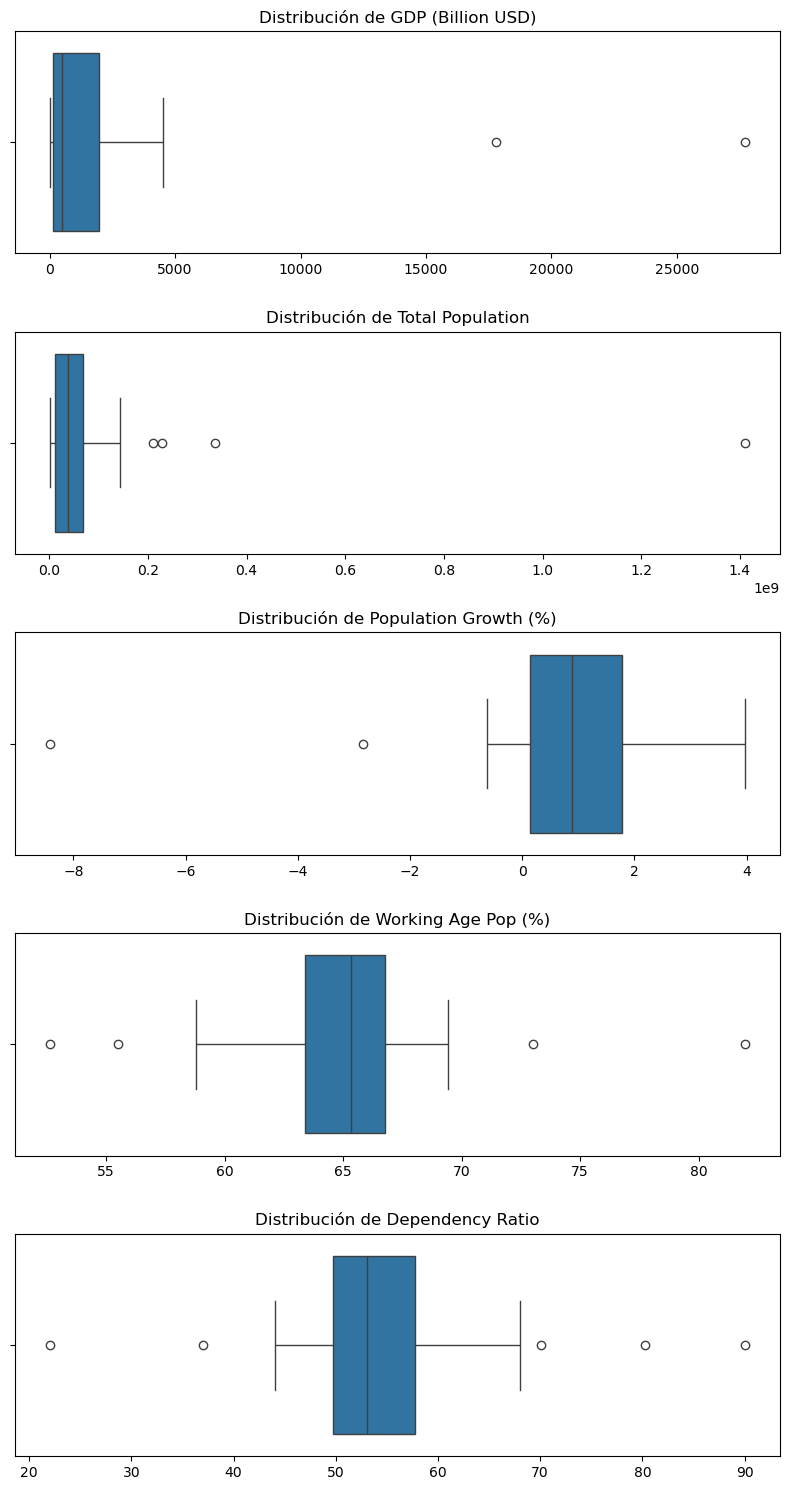

In [41]:
# Obtener los datos
query = """
    SELECT gdp_2023_billion_usd, total_population, population_growth_2023, 
           working_age_pop_percent, dependency_ratio_2023
    FROM country_data;
"""
result = session.execute(text(query))
df_country = pd.DataFrame(result.fetchall(), columns=['GDP (Billion USD)', 'Total Population', 
                                                      'Population Growth (%)', 'Working Age Pop (%)', 
                                                      'Dependency Ratio'])

# Crear boxplots individuales
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 15))  
variables = df_country.columns

for i, var in enumerate(variables):
    sns.boxplot(data=df_country[var], ax=axes[i], orient='h')
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()



Observando las distintas distribuciones, podemos concluir que:  

**1. GDP (Producto Interno Bruto en miles de millones de USD)**  
- Hay una gran variabilidad en los valores del PIB entre los países.  
- La mayoría de los países tienen un PIB relativamente bajo, mientras que unos pocos presentan valores extremadamente altos, lo que genera valores atípicos (probablemente grandes economías como EE.UU. o China).  

**2. Población total**  
- Se observa una distribución sesgada con la mayoría de los países teniendo poblaciones relativamente bajas.  
- Hay valores atípicos significativos correspondientes a países con poblaciones extremadamente altas (posiblemente India y China).  

**3. Crecimiento de la población (%)**  
- La mayoría de los países tienen tasas de crecimiento entre 0 % y 3 %, pero existen valores negativos que indican países con decrecimiento poblacional.  
- También se observan algunos valores atípicos con caídas drásticas en la población.  

**4. Porcentaje de población en edad de trabajar**  
- La mayor parte de los países tienen entre el 60 % y el 70 % de su población en edad de trabajar.  
- Existen algunos valores atípicos con porcentajes significativamente más bajos o más altos, lo que podría estar relacionado con envejecimiento poblacional o estructuras demográficas particulares.  

**5. Ratio de dependencia**  
- La mediana del ratio de dependencia se encuentra alrededor de 50-60 %, indicando que en la mayoría de los países, cada persona en edad de trabajar debe sostener a aproximadamente 0.5-0.6 personas dependientes.  
- Existen valores atípicos con ratios extremadamente altos, lo que sugiere poblaciones envejecidas o con una alta proporción de jóvenes dependientes.  



#### 2) events_stats

La unica variable de la que tiene sentido analizar la distribucion, es de la variable attendance , que representa la asistencia de cada evento:

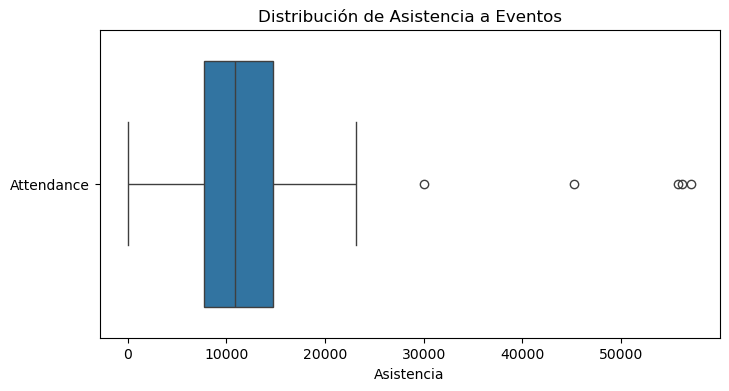

In [42]:
# Obtener los datos de asistencia a eventos
query = """
    SELECT attendance
    FROM events_stats;
"""
result = session.execute(text(query))
df_events = pd.DataFrame(result.fetchall(), columns=['Attendance'])

# Crear boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_events, orient='h')
plt.title("Distribución de Asistencia a Eventos")
plt.xlabel("Asistencia")
plt.show()


**Comentarios acerca de la asistencia a eventos**  
- La distribución de la asistencia a eventos muestra una gran variabilidad en los datos.  
- La mediana se encuentra alrededor de los **10000 asistentes**, lo que indica que en la mayoría de los eventos la asistencia se sitúa cerca de este valor.  
- Se observa una **asimetría positiva**, con valores atípicos en el extremo superior que representan eventos con asistencias mucho mayores al promedio.  
- Algunos eventos han registrado asistencias superiores a **30000, 40000 e incluso 50000 asistentes**, lo que indica la existencia de megaeventos con una audiencia significativamente superior al resto.  
- La presencia de estos valores atípicos sugiere que, si bien la mayoría de los eventos tienen una asistencia moderada, existen ciertos casos excepcionales con una concurrencia masiva.  


#### 3) fighters_stats

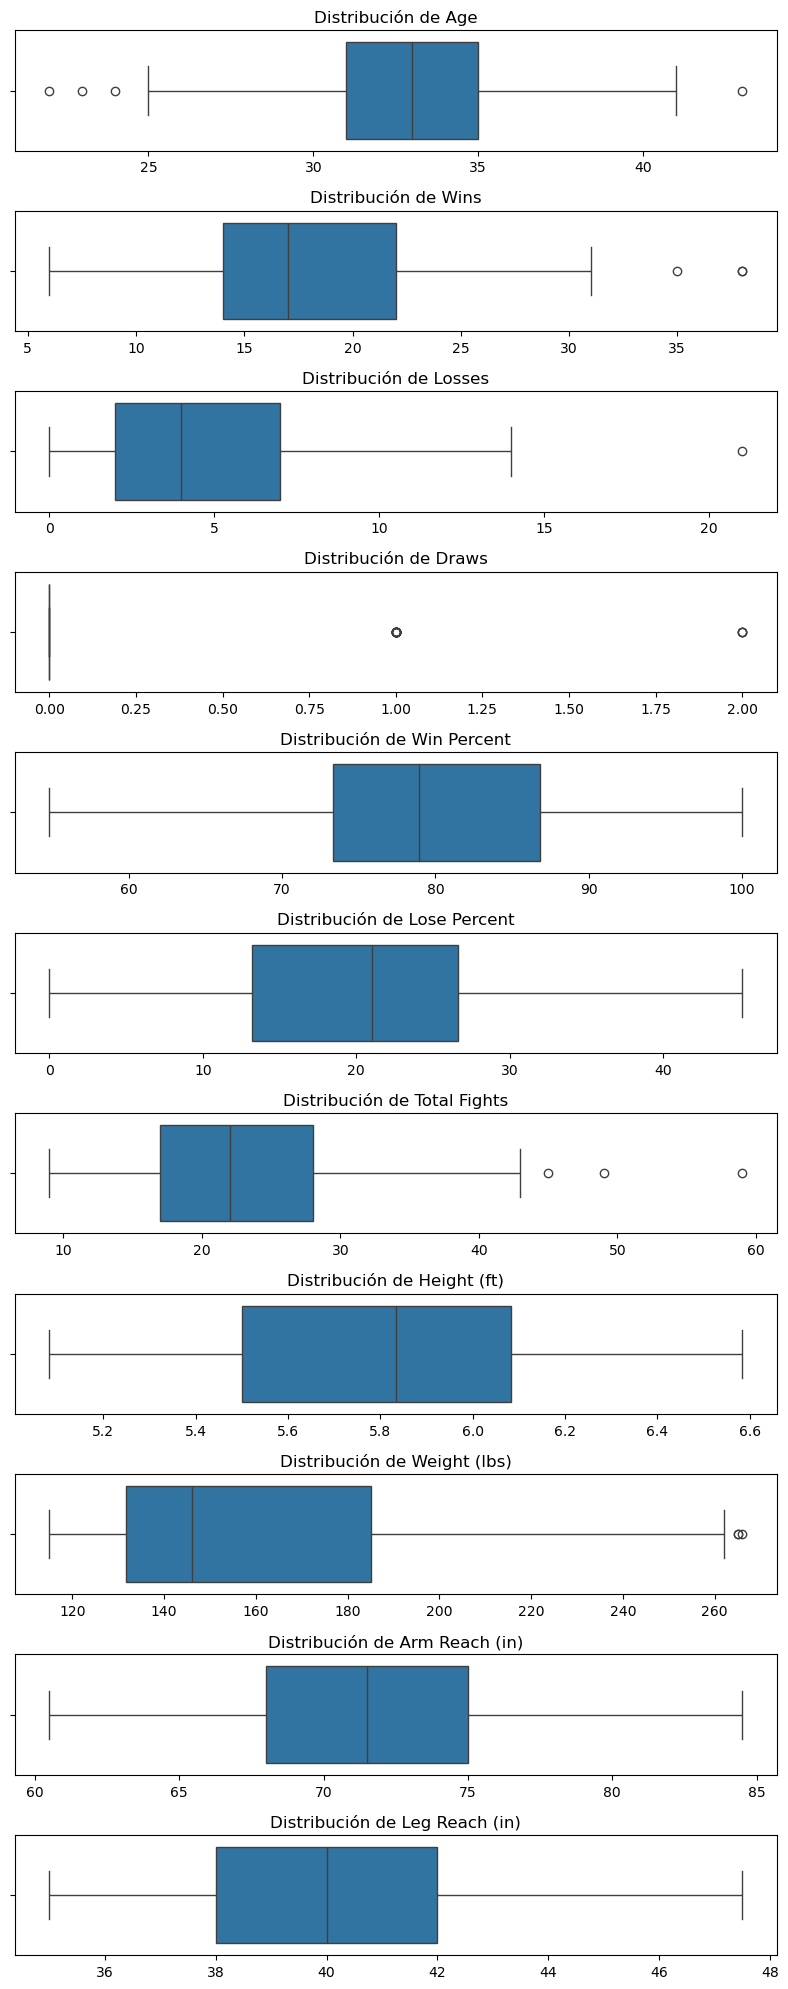

In [43]:
# Obtener los datos de fighters_stats
query = """
    SELECT age, wins, losses, draws, win_percent, lose_percent, num_of_fights,
           height_ft, weight_lbs, arm_reach_inch, leg_reach_inch
    FROM fighters_stats;
"""
result = session.execute(text(query))
df_fighters = pd.DataFrame(result.fetchall(), columns=['Age', 'Wins', 'Losses', 'Draws', 
                                                       'Win Percent', 'Lose Percent', 'Total Fights', 
                                                       'Height (ft)', 'Weight (lbs)', 
                                                       'Arm Reach (in)', 'Leg Reach (in)'])

# Crear boxplots individuales
fig, axes = plt.subplots(nrows=len(df_fighters.columns), ncols=1, figsize=(8, 20))

for i, var in enumerate(df_fighters.columns):
    sns.boxplot(data=df_fighters[var], ax=axes[i], orient='h')
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()


Observando las distintas distribuciones, podemos concluir que:

**1. Edad**: 

- La mayoría de los peleadores tienen entre 28 y 36 años, con algunos valores atípicos menores de 25 y mayores de 40.

**2. Victorias y derrotas**:

- Hay una amplia dispersión en el número de victorias, con un rango intercuartílico entre 12 y 25. Sin embargo, hay peleadores con más de 35 victorias que se consideran valores atípicos.
- Las derrotas tienen una distribución más homogénea, con la mayoría de los peleadores entre 0 y 10 derrotas.

**3. Empates**: 

- La mayoría de los peleadores tienen 0 empates, lo que sugiere que los combates suelen terminar en victoria o derrota. Sin embargo, hay algunos peleadores con hasta 2 empates, considerados atípicos.

**4. Porcentaje de victorias y derrotas**:

- La mediana del porcentaje de victorias está alrededor del 80 %, lo que indica que la mayoría de los peleadores han ganado una proporción alta de sus combates.
El porcentaje de derrotas muestra una mayor variabilidad, con algunos peleadores perdiendo casi todos sus combates.

**5. Número total de peleas**:

- La mayoría de los peleadores han tenido entre 10 y 35 peleas, pero hay valores atípicos con más de 50 combates, lo que sugiere peleadores con carreras muy largas.

**6. Altura y peso**:

- La altura tiene una distribución relativamente homogénea, con la mayoría de los peleadores entre 5'6" y 6'0".
- El peso muestra una mayor variabilidad debido a las diferentes categorías de peso en la competencia. Hay peleadores más ligeros en torno a 120-140 libras y otros en el extremo superior con más de 260 libras (posibles pesos pesados).

**7. Alcance de brazos y piernas**:

- Ambos muestran distribuciones similares, con la mayoría de los peleadores teniendo un alcance de brazos entre 65 y 75 pulgadas, y de piernas entre 36 y 44 pulgadas.

### Analisis Multivariante Grafico

Ahora realizaremos un analisis para mostrar las relaciones entre dos o mas variables del conjunto de datos, estos son los mas interesantes:

#### 1) Evaluación de la Calidad de los Luchadores por País: Relación entre el Porcentaje de Victorias y la Nacionalidad

Con este analisis podriamos ver la "calidad" de los luchadores de cada pais, siendo los paises con una media de porcentaje de victorias mas altos lo paises de los cuales provienen los mejores luchadores.

/tmp/ipykernel_200/2398659442.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='country', y='avg_wins', data=fighters_country_data, palette=colors)


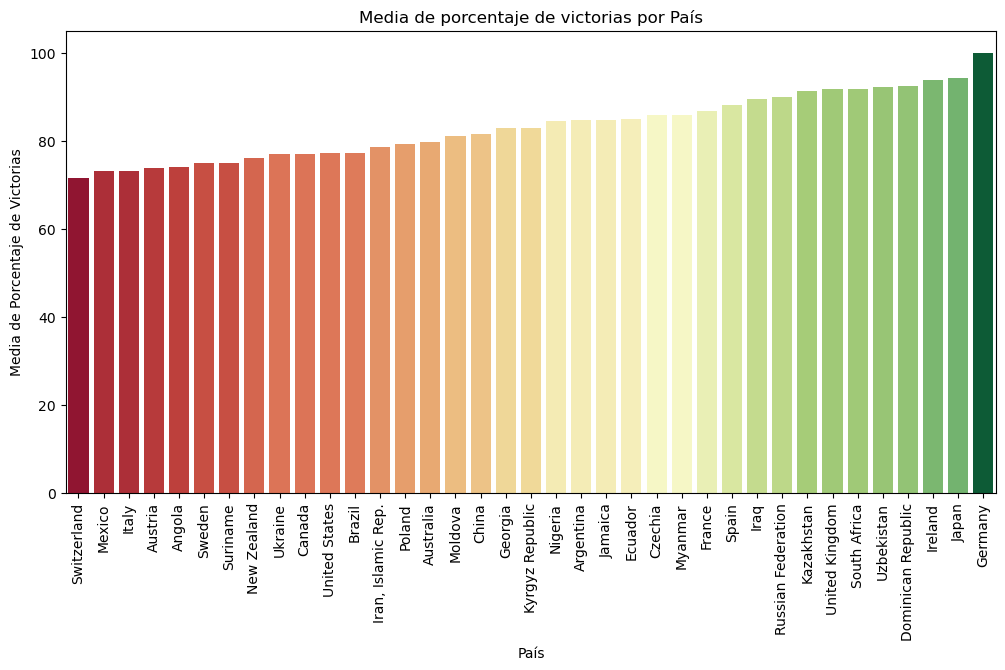

In [44]:
query = """
    SELECT f.country, AVG(f.win_percent) AS avg_wins
    FROM fighters_stats f
    GROUP BY f.country;
"""

# Ejecutar la consulta y obtener los resultados
result = session.execute(text(query))

# Convertir los resultados a un DataFrame
fighters_country_data = pd.DataFrame(result.fetchall(), columns=['country', 'avg_wins'])

# Ordenar por media de victorias para mejor visualización
fighters_country_data = fighters_country_data.sort_values(by='avg_wins', ascending=True)

# Normalizar los valores para asignar colores (asegurando que sean tipo float)
norm = (fighters_country_data['avg_wins'] - fighters_country_data['avg_wins'].min()) / \
       (fighters_country_data['avg_wins'].max() - fighters_country_data['avg_wins'].min())

# Convertir a tipo float explícitamente
norm = norm.astype(float)

# Crear una lista de colores (de rojo a verde)
colors = [plt.cm.RdYlGn(value) for value in norm.to_numpy()]

# Graficar un histograma donde cada barra representa un país
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='avg_wins', data=fighters_country_data, palette=colors)

plt.title('Media de porcentaje de victorias por País')
plt.xlabel('País')
plt.ylabel('Media de Porcentaje de Victorias')
plt.xticks(rotation=90)  # Rotar los nombres de los países para mejor visibilidad
plt.show()

Podemos observar que Alemania tiene los luchadores con mayor calidad, teniendo un porcentaje de victorias del 100% ( por lo tanto podemos suponer que el/los luchador/es de Alemania son invictos). El pais con la peor calidad de luchadores es Suiza cuyo porcentaje de victorias es inferior al 75%.

#### 2) Análisis de la Relación entre la Asistencia a Eventos y la Población de Cada País

Aqui lo que queremos identificar si existe una relacion entre la asistencia a eventos y la poblacion de un pais, es decir, queremos ver si tener una gran poblacion en un pais implica a tener una mayor asistencia promedio a los eventos de UFC

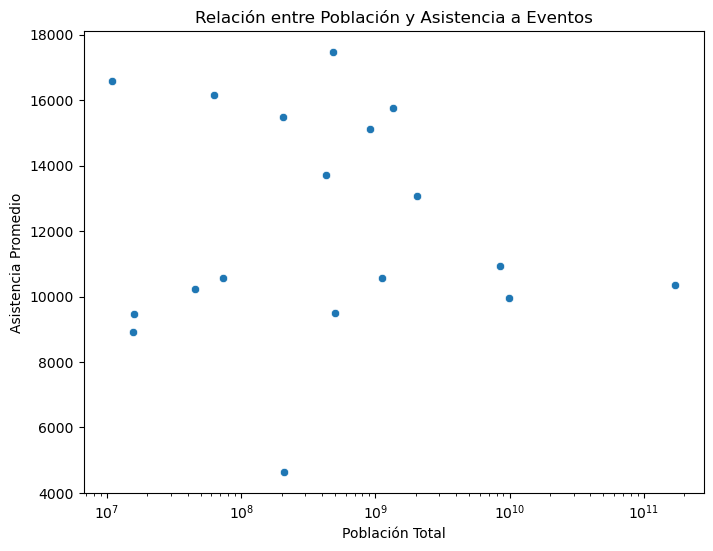

In [45]:
query = """
SELECT e.country, 
       SUM(c.total_population) AS total_population, 
       AVG(e.attendance) AS avg_attendance
FROM events_stats e
JOIN country_data c ON e.country = c.country
GROUP BY e.country
ORDER BY total_population DESC;

"""

# Ejecutar la consulta
result = session.execute(text(query))

# Convertir a DataFrame
df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Crear scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["total_population"], y=df["avg_attendance"])
plt.xlabel("Población Total")
plt.ylabel("Asistencia Promedio")
plt.title("Relación entre Población y Asistencia a Eventos")
plt.xscale("log")  # Escala logarítmica para normalizar valores extremos
plt.show()



No hay una correlación directa entre la población total de un país y la asistencia promedio a eventos de UFC, ya que los puntos están bastante dispersos en el gráfico. Si existiera una fuerte correlación, esperaríamos ver una tendencia clara en la que la asistencia aumentara a medida que la población crece. Sin embargo, observamos que algunos países con una población menor tienen una alta asistencia, lo que sugiere que factores como el interés en las artes marciales mixtas pueden ser más determinantes que el tamaño de la población

#### 3) Análisis de los Rangos de Peso en las Divisiones de Combate

Podemos identificar los rangos de peso de cada división al analizar los pesos de los luchadores y las categorías a las que pertenecen.

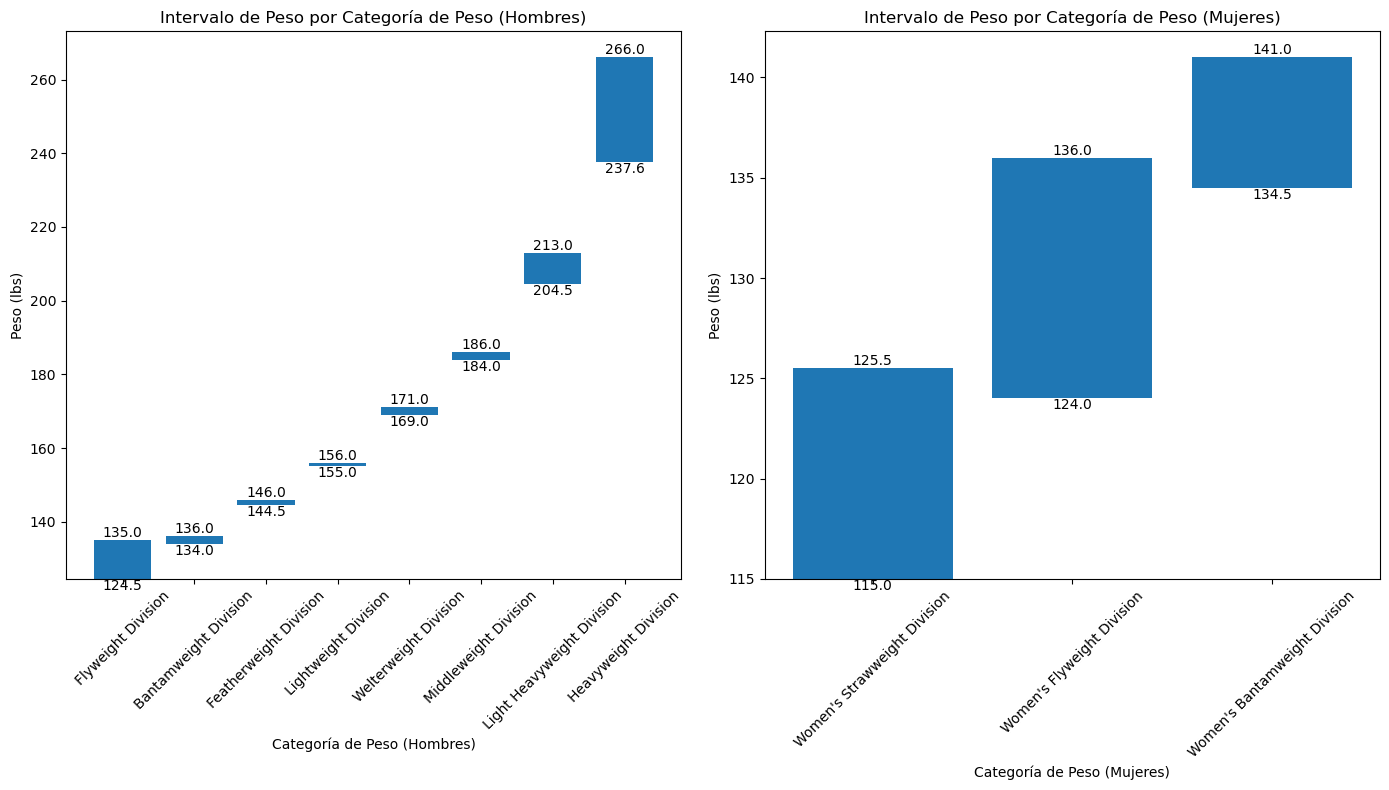

In [46]:
query = """
SELECT f.weight_division,
       MIN(f.weight_lbs) AS min_weight,
       MAX(f.weight_lbs) AS max_weight
FROM fighters_stats f
GROUP BY f.weight_division
ORDER BY (MAX(f.weight_lbs) - MIN(f.weight_lbs))
"""
result = session.execute(text(query))

# Convertir a DataFrame
df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Función para asignar el género según el nombre de la categoría de peso
def assign_gender(weight_division):
    # Si el nombre de la categoría contiene "Women", asignamos 'Female', sino 'Male'
    if 'Women' in weight_division:
        return 'Female'
    else:
        return 'Male'

# Asignar el género al DataFrame
df['gender'] = df['weight_division'].apply(assign_gender)

# Separar hombres y mujeres
df_men = df[df['gender'] == 'Male'].sort_values(by='max_weight')  # Ordenar por peso máximo
df_women = df[df['gender'] == 'Female'].sort_values(by='max_weight')  # Ordenar por peso máximo

# Graficar los intervalos de peso por género
plt.figure(figsize=(14,8))

# Gráfico para hombres
plt.subplot(1, 2, 1)
bars_men = plt.bar(df_men['weight_division'], df_men['max_weight'] - df_men['min_weight'], bottom=df_men['min_weight'])
plt.xlabel('Categoría de Peso (Hombres)')
plt.ylabel('Peso (lbs)')
plt.title('Intervalo de Peso por Categoría de Peso (Hombres)')
plt.xticks(rotation=45)

# Añadir los valores de max y min encima y debajo de las barras
for i, bar in enumerate(bars_men):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f'{df_men["max_weight"].iloc[i]}', ha='center', va='bottom', fontsize=10)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y(), f'{df_men["min_weight"].iloc[i]}', ha='center', va='top', fontsize=10)

# Gráfico para mujeres
plt.subplot(1, 2, 2)
bars_women = plt.bar(df_women['weight_division'], df_women['max_weight'] - df_women['min_weight'], bottom=df_women['min_weight'])
plt.xlabel('Categoría de Peso (Mujeres)')
plt.ylabel('Peso (lbs)')
plt.title('Intervalo de Peso por Categoría de Peso (Mujeres)')
plt.xticks(rotation=45)

# Añadir los valores de max y min encima y debajo de las barras
for i, bar in enumerate(bars_women):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f'{df_women["max_weight"].iloc[i]}', ha='center', va='bottom', fontsize=10)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y(), f'{df_women["min_weight"].iloc[i]}', ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.show()




Hemos realizado una separación entre las categorías de peso masculinas y femeninas, dado que los combates se llevan a cabo por género. Como resultado, hemos obtenido los rangos de peso correspondientes a cada división de luchadores. Al analizar los datos, observamos que las divisiones de peso "Flyweight" y "Bantamweight" y tambien en todas las divisiones femeninas presentan un solapamiento en sus rangos, lo cual podría explicarse por la práctica común de que los luchadores ajusten su peso, subiendo o bajando, para competir en diferentes divisiones.

#### 4) Análisis de la Relación entre la Altura y el Alcance de Brazos y Piernas

Ahora analizaremos la **relación entre la altura y el alcance de brazos y piernas** en los luchadores. El objetivo es determinar si, a medida que aumenta la altura, también lo hace el alcance de sus extremidades, lo que podría indicar una proporción constante en la estructura corporal de los peleadores.

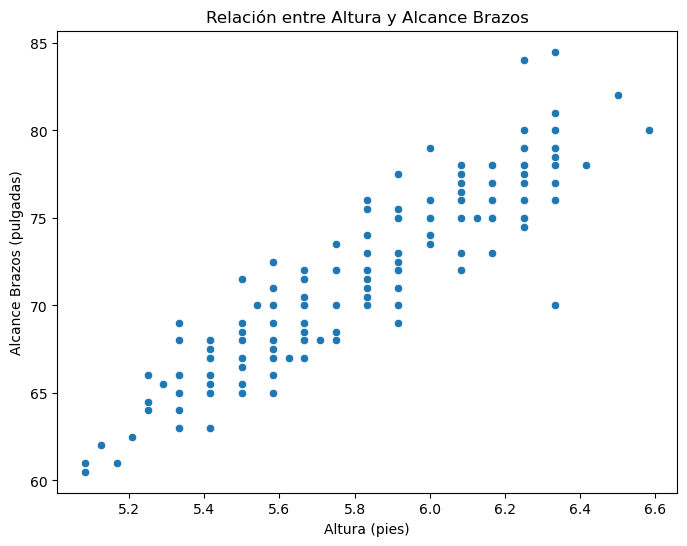

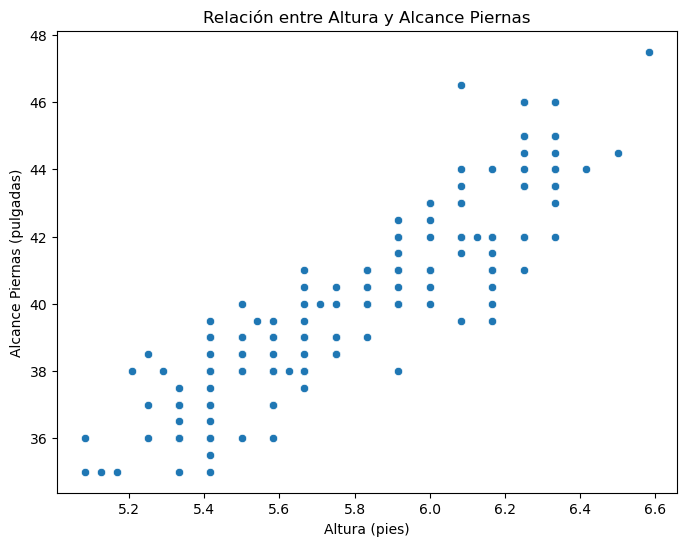


Matriz de Correlación:
                 height_ft  arm_reach_inch  leg_reach_inch
height_ft            1.00            0.92            0.90
arm_reach_inch       0.92            1.00            0.85
leg_reach_inch       0.90            0.85            1.00


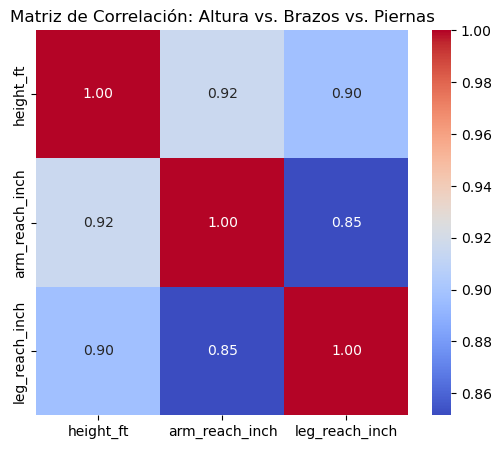

In [47]:
query = """
SELECT height_ft, 
       arm_reach_inch, 
       leg_reach_inch
FROM fighters_stats
"""

result = session.execute(text(query))

# Convertir a DataFrame
df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Crear scatter plot Altura vs Alcance Brazos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["height_ft"], y=df["arm_reach_inch"])
plt.xlabel("Altura (pies)")
plt.ylabel("Alcance Brazos (pulgadas)")
plt.title("Relación entre Altura y Alcance Brazos")
plt.show()

# Crear scatter plot Altura vs Alcance Piernas
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["height_ft"], y=df["leg_reach_inch"])
plt.xlabel("Altura (pies)")
plt.ylabel("Alcance Piernas (pulgadas)")
plt.title("Relación entre Altura y Alcance Piernas")
plt.show()

# Calcular matriz de correlación
correlation_matrix = df.corr()
print("\nMatriz de Correlación:\n", correlation_matrix)

# Mostrar heatmap de la correlación
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación: Altura vs. Brazos vs. Piernas")
plt.show()


Podemos observar en los scatterplots un **patrón claro de crecimiento** a medida que aumentan la altura, el **alcance de brazos** y el **alcance de piernas**. Esto indica una relación positiva entre estas variables.  

Además, al analizar la **matriz de correlación**, vemos que los valores de correlación entre las tres variables son **altos**, lo que sugiere que existe una fuerte asociación entre ellas. En otras palabras, cuando una de estas medidas aumenta, es muy probable que las demás también lo hagan.  

Este resultado respalda la idea de que la **altura de un peleador está estrechamente relacionada con su alcance de brazos y piernas**, lo cual tiene sentido desde una perspectiva anatómica y deportiva.